Datathon - Machine Learning Engineering - Grupo 34 - Pos Tech FIAP - 22/05/2025

Applicants

In [2]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from statsmodels.tools.tools import add_constant
from mlflow.models import infer_signature
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import mlflow
import joblib
import json
import os

In [3]:
# mlflow server --host localhost --port 9000 # NECESSÁRIO RODAR PARA INICIAR O SERVIDOR.
"""
mlflow server --backend-store-uri sqlite:///mlflow.db --default-artifact-root ./mlruns --host localhost --port 9000
"""
mlflow.set_tracking_uri(uri="http://localhost:9000")

# Create a new MLflow Experiment
mlflow.set_experiment("MLflow Recrutamento & seleção")

<Experiment: artifact_location='file:///C:/Users/wiwil/Desktop/PROGRAMACAO/POSTECH/FASE_05/mlruns/1', creation_time=1745279658603, experiment_id='1', last_update_time=1745279658603, lifecycle_stage='active', name='MLflow Recrutamento & seleção', tags={}>

In [4]:
def processar_json(caminho_arquivo, key):
    with open(caminho_arquivo, 'r', encoding='utf-8') as f:
        data:dict = json.load(f)
    
    registros:list = []
    for id_profissional, dados in data.items():
        registro = {key: id_profissional}  # Adiciona o ID como coluna
        
        # Percorre todas as seções do JSON
        for secao, valores in dados.items():
            if isinstance(valores, dict):  # Se a seção tiver subitens, adiciona normalmente
                registro.update(valores)
            else:  # Se for um valor único (ex: cv_pt, cv_en, cargo_atual vazio)
                registro[secao] = valores
        
        registros.append(registro)

    return pd.DataFrame(registros)

# Nome do arquivo JSON
caminho_arquivo = os.path.join(os.getcwd(), "files", "applicants.json")

if os.path.exists(caminho_arquivo):
    applicants:pd = processar_json(caminho_arquivo, "id_candidato")
    print("Arquivo encontrado e carregado com sucesso!")
else:
    print("Arquivo não encontrado.")
    
applicants.head()

Arquivo encontrado e carregado com sucesso!


,id_candidato,telefone_recado,telefone,objetivo_profissional,data_criacao,inserido_por,email,local,sabendo_de_nos_por,data_atualizacao,...,id_ibrati,email_corporativo,cargo_atual,projeto_atual,cliente,unidade,data_admissao,data_ultima_promocao,nome_superior_imediato,email_superior_imediato
0,31000,,(11) 97048-2708,,10-11-2021 07:29:49,Luna Correia,carolina_aparecida@gmail.com,,,10-11-2021 07:29:49,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,31001,,(11) 93723-4396,Analista Administrativo,10-11-2021 08:56:16,Laura Pacheco,eduardo_rios@hotmail.com,"São Paulo, São Paulo",Outros,11-11-2021 11:10:31,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,31002,,(11) 92399-9824,Administrativo | Financeiro,10-11-2021 09:01:00,Laura Pacheco,pedro_henrique_carvalho@gmail.com,"São Paulo, São Paulo",Anúncio,10-11-2021 11:42:36,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,31003,,(11) 98100-1727,Área administrativa,10-11-2021 09:08:13,Laura Pacheco,thiago_barbosa@hotmail.com,"São Paulo, São Paulo",Site de Empregos,10-11-2021 16:04:51,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,31004,,(11) 92517-2678,,10-11-2021 09:18:46,Maria Clara Pires,diogo_das_neves@hotmail.com,,,10-11-2021 09:22:03,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [6]:
applicants.shape

(42482, 55)

Vagas

In [7]:
nome_arquivo = "vagas.json"

caminho_arquivo = os.path.join(os.getcwd(), "files", "vagas.json")

if os.path.exists(caminho_arquivo):
    vagas = processar_json(caminho_arquivo, key="id_vaga")
    print("Arquivo encontrado e carregado com sucesso!")
else:
    print("Arquivo não encontrado.")

Arquivo encontrado e carregado com sucesso!


In [8]:
pd.set_option('display.max_columns', None)

In [9]:
vagas.shape

(14081, 45)

Prospects

In [10]:
def processar_json_para_dataframe(json_data:dict):
    dados:list = []

    for id_vaga, vaga_info in json_data.items():
        vaga_info:dict
        
        titulo = vaga_info.get("titulo", "")
        modalidade = vaga_info.get("modalidade", "")

        # Se houver uma lista dentro do JSON, criamos múltiplas linhas
        if "prospects" in vaga_info:
            for prospect in vaga_info["prospects"]:
                linha = {"id_vaga": id_vaga, "titulo": titulo, "modalidade": modalidade}
                linha.update(prospect)  # Adiciona os dados de prospects como colunas
                dados.append(linha)
        else:
            dados.append({"id_vaga": id_vaga, "titulo": titulo, "modalidade": modalidade})

    return pd.DataFrame(dados)

# Caminho do arquivo JSON
caminho_arquivo = os.path.join(os.getcwd(), "files", "prospects.json")

if os.path.exists(caminho_arquivo):
    # Carregar JSON
    with open(caminho_arquivo, "r", encoding="utf-8") as file:
        json_data = json.load(file)

    # Converter para DataFrame
    prospects = processar_json_para_dataframe(json_data)

In [11]:
pd.set_option('display.max_columns', None)
# Renomeando a coluna 'codigo' para 'id_candidato'
prospects.rename(columns={'codigo': 'id_candidato', 'cidade': 'cidade_vaga'}, inplace=True)

In [12]:
prospects.shape

(53759, 10)

Análise Exploratória de Dados

In [13]:
# Unir Prospects com Applicants (vaga -> candidato)
prospects_applicants = prospects.merge(applicants, left_on="id_candidato", right_on="id_candidato", how="left")

# Unir com Vagas (vaga -> detalhes da vaga)
df = prospects_applicants.merge(vagas, left_on="id_vaga", right_on="id_vaga", how="left")

In [14]:
df.shape

(53759, 108)

In [15]:
# Remover 'nome_y'
df = df.drop(columns=['nome_y'], errors='ignore')

# Renomear colunas
df = df.rename(columns=lambda col: col.replace('_x', '_candidato').replace('_y', '_vaga'))
df = df.rename(columns={"local": "cidade_candidato", "cidade": "cidade_vaga", "nivel profissional": "nivel_profissional_vaga", 
                        "areas_atuacao": "areas_atuacao_vaga", "nivel_profissional": "nivel_profissional_candidato",
                        "cursos": "cursos_candidato", "remuneracao": "remuneracao_candidato"})

In [16]:
# Separando as colunas a serem usadas

df = df[['situacao_candidado','recrutador','cidade_candidato',
                'data_nascimento','sexo','estado_civil','pcd','remuneracao_candidato','nivel_profissional_candidato',
                'nivel_academico_candidato',
                'nivel_ingles_candidato','nivel_espanhol_candidato','cursos_candidato',
                'cliente_vaga','tipo_contratacao',
                'prioridade_vaga','origem_vaga','cidade_vaga',
                'nivel_profissional_vaga','nivel_academico_vaga','nivel_ingles_vaga','nivel_espanhol_vaga',
                'areas_atuacao_vaga','ultima_atualizacao']]

In [17]:
df.shape

(53759, 24)

In [18]:
print(f'Linhas duplicadas: {df.duplicated().sum()}')

Linhas duplicadas: 8274


In [19]:
df.drop_duplicates(inplace=True)  # Remove duplicatas

In [20]:
# Convertendo as colunas para datetime, tratando erros
df[['data_nascimento','ultima_atualizacao']] = df[
    ['data_nascimento','ultima_atualizacao']].apply(
    lambda col: pd.to_datetime(col, errors='coerce', format='%d-%m-%Y'))

In [21]:
# Extraindo apenas os números e convertendo para inteiro
df['remuneracao_candidato'] = (
    df['remuneracao_candidato']
    .str.replace(r'[^\d,.-]', '', regex=True)  # Remove tudo que não for número, vírgula, ponto ou hífen
    .str.replace(',', '.', regex=False)  # Substitui vírgula por ponto
    .str.extract(r'(-?\d+\.?\d*)')  # Captura o primeiro número válido
    .astype(float)  # Converte para float primeiro
    .fillna(0)  # Substitui NaN por 0 (opcional)
    .astype(int)  # Converte para inteiro
)

In [22]:
# Calculando a idade (diferenca entre anos)
df['idade'] = df['ultima_atualizacao'].dt.year - df['data_nascimento'].dt.year
# Removendo as colunas 'data_nascimento' e 'ultima_atualizacao'
df = df.drop(columns=['data_nascimento', 'ultima_atualizacao'])

In [23]:
df.describe(include="all")

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
count,45485,45485,39281,39281,39281,39281,4.548500e+04,39281,39281,39281,39281,10901,45462,45462,45462,45462,45462,45462,45462,45462,45462,45462,14114.000000
unique,21,77,615,3,7,3,NaN,10,22,6,6,127,111,40,4,3,155,14,15,6,7,71,NaN
top,Prospect,Srta. Bella Ferreira,,,,,NaN,,,,,,Morrison Ltd,PJ/Autônomo,Alta: Alta complexidade 3 a 5 dias,Nova Posição,São Paulo,Sênior,Ensino Superior Completo,Básico,Nenhum,TI - Projetos-,NaN
freq,15430,4462,18802,26683,28605,28974,NaN,38988,27564,28092,28392,1065,6274,15694,30139,30012,32801,18014,35135,15790,20235,18005,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1.996147e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,44.983562
std,NaN,NaN,NaN,NaN,NaN,NaN,1.455928e+07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12.234396
min,NaN,NaN,NaN,NaN,NaN,NaN,-4.700000e+03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,50.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,52.000000


In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 45485 entries, 0 to 53758
Data columns (total 23 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   situacao_candidado            45485 non-null  object 
 1   recrutador                    45485 non-null  object 
 2   cidade_candidato              39281 non-null  object 
 3   sexo                          39281 non-null  object 
 4   estado_civil                  39281 non-null  object 
 5   pcd                           39281 non-null  object 
 6   remuneracao_candidato         45485 non-null  int64  
 7   nivel_profissional_candidato  39281 non-null  object 
 8   nivel_academico_candidato     39281 non-null  object 
 9   nivel_ingles_candidato        39281 non-null  object 
 10  nivel_espanhol_candidato      39281 non-null  object 
 11  cursos_candidato              10901 non-null  object 
 12  cliente_vaga                  45462 non-null  object 
 13  tipo_c

In [25]:
df.head()

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
0,Encaminhado ao Requisitante,Ana Lívia Moreira,,,,,0,,,,,NaN,"Morris, Moran and Dodson",PJ/Autônomo,,,Rio de Janeiro,Pleno,Ensino Superior Completo,Nenhum,Nenhum,TI - Desenvolvimento/Programação-,NaN
1,Encaminhado ao Requisitante,Ana Lívia Moreira,"Rio de Janeiro, Rio de Janeiro",Masculino,Solteiro,Não,5600,,Ensino Superior Completo,Intermediário,Básico,,"Morris, Moran and Dodson",PJ/Autônomo,,,Rio de Janeiro,Pleno,Ensino Superior Completo,Nenhum,Nenhum,TI - Desenvolvimento/Programação-,48.0
2,Contratado pela Decision,Juliana Cassiano,"São Paulo, São Paulo",Masculino,Casado,Não,15,,Ensino Superior Completo,Avançado,Intermediário,Tecnologia da Informação,Gonzalez and Sons,PJ/Autônomo,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Nenhum,Nenhum,Gestão e Alocação de Recursos de TI-,48.0
3,Encaminhado ao Requisitante,Juliana Cassiano,,,,,0,,,,,NaN,Gonzalez and Sons,PJ/Autônomo,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Nenhum,Nenhum,Gestão e Alocação de Recursos de TI-,NaN
4,Contratado pela Decision,Stella Vieira,,,,,0,,,,,NaN,Barnes-Woods,PJ/Autônomo,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Técnico,Fluente,Gestão e Alocação de Recursos de TI-,NaN


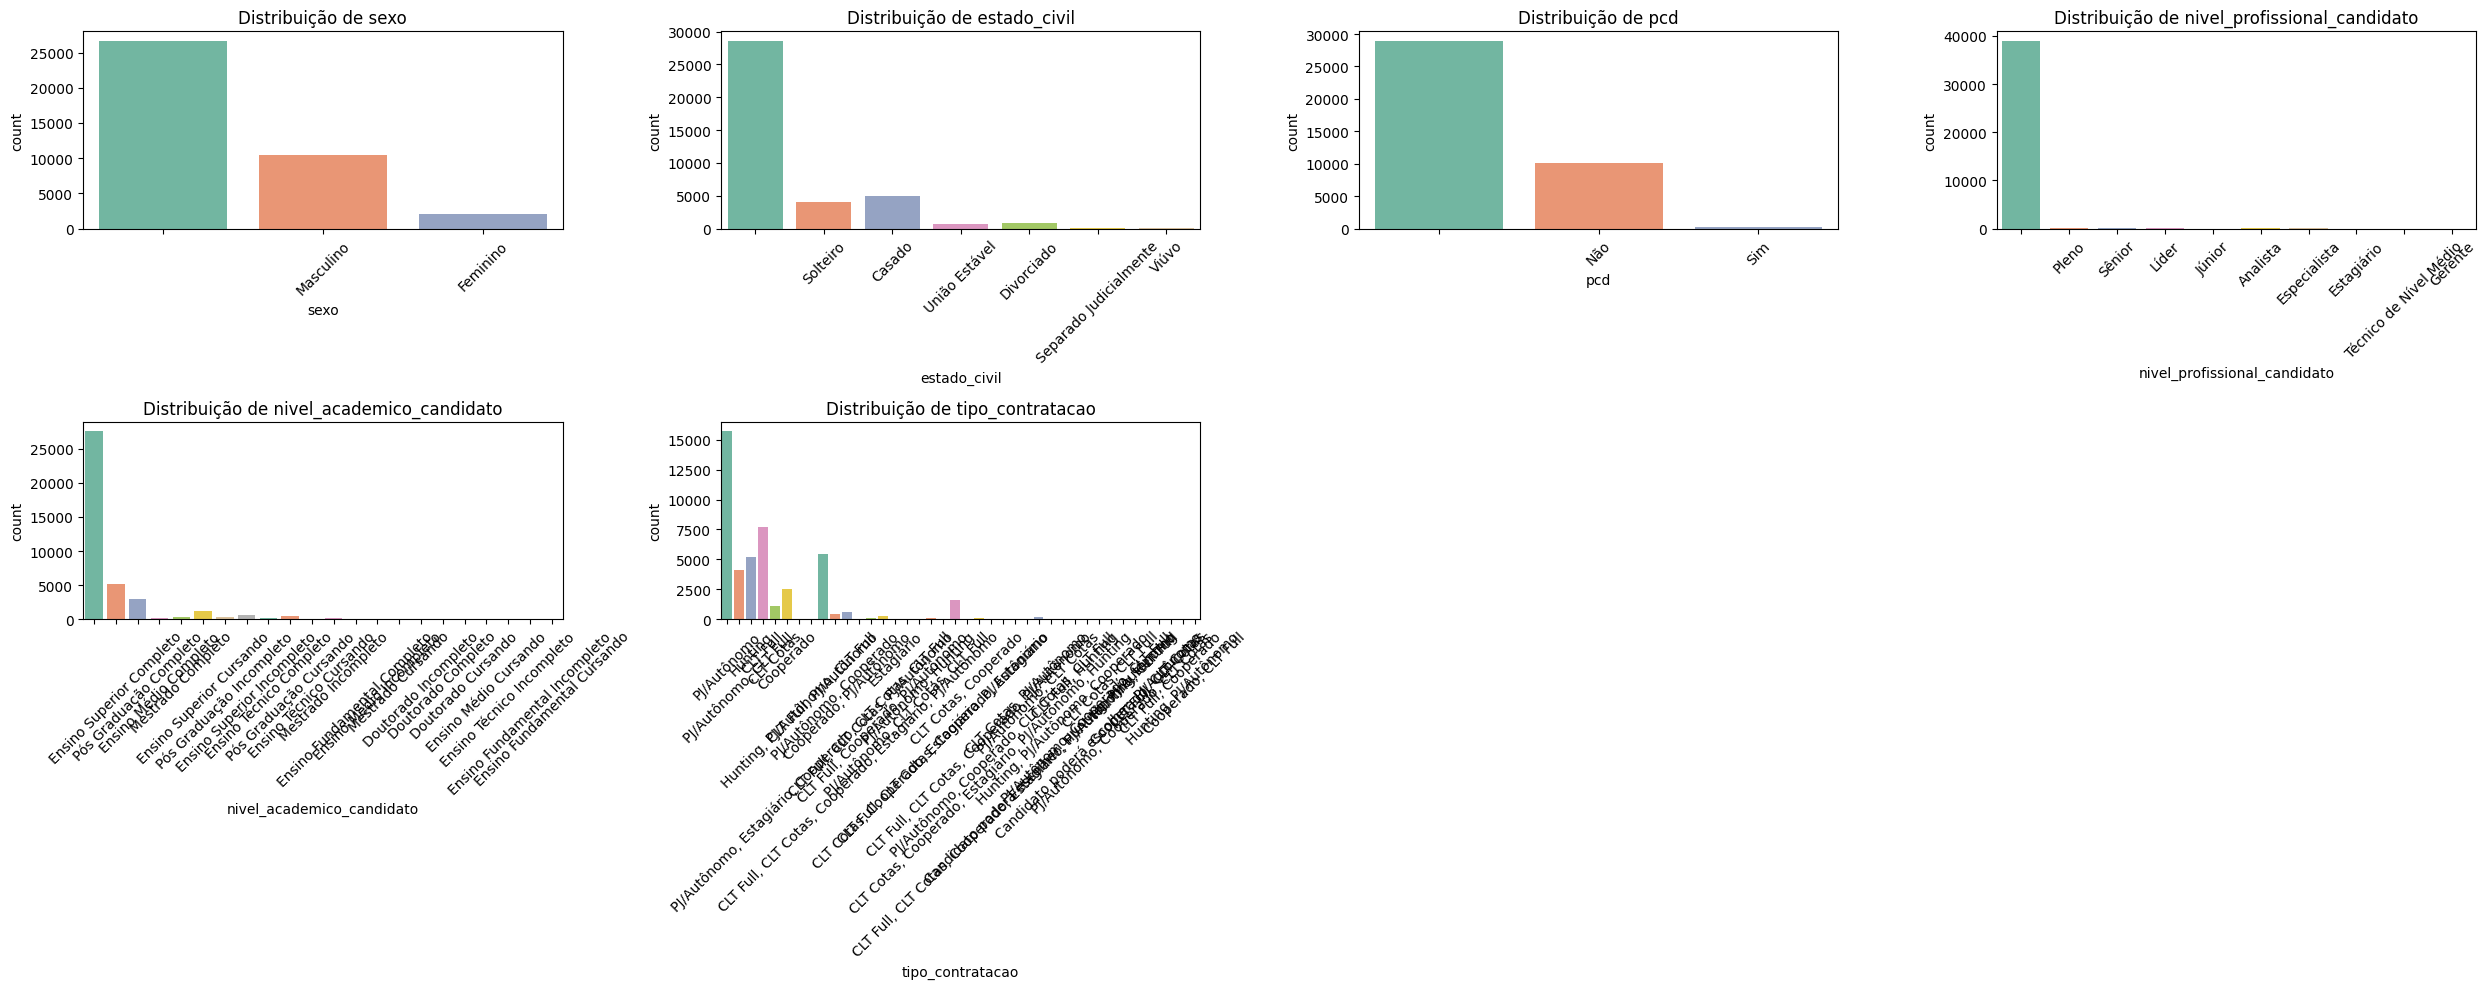

In [26]:
warnings.filterwarnings("ignore")

# Gráficos de barras para variáveis categóricas
categorical_columns = ['sexo', 'estado_civil', 'pcd', 'nivel_profissional_candidato', 'nivel_academico_candidato', 'tipo_contratacao']

plt.figure(figsize=(25, 10))
for i, col in enumerate(categorical_columns, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=df[col], palette='Set2')
    plt.title(f'Distribuição de {col}')
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

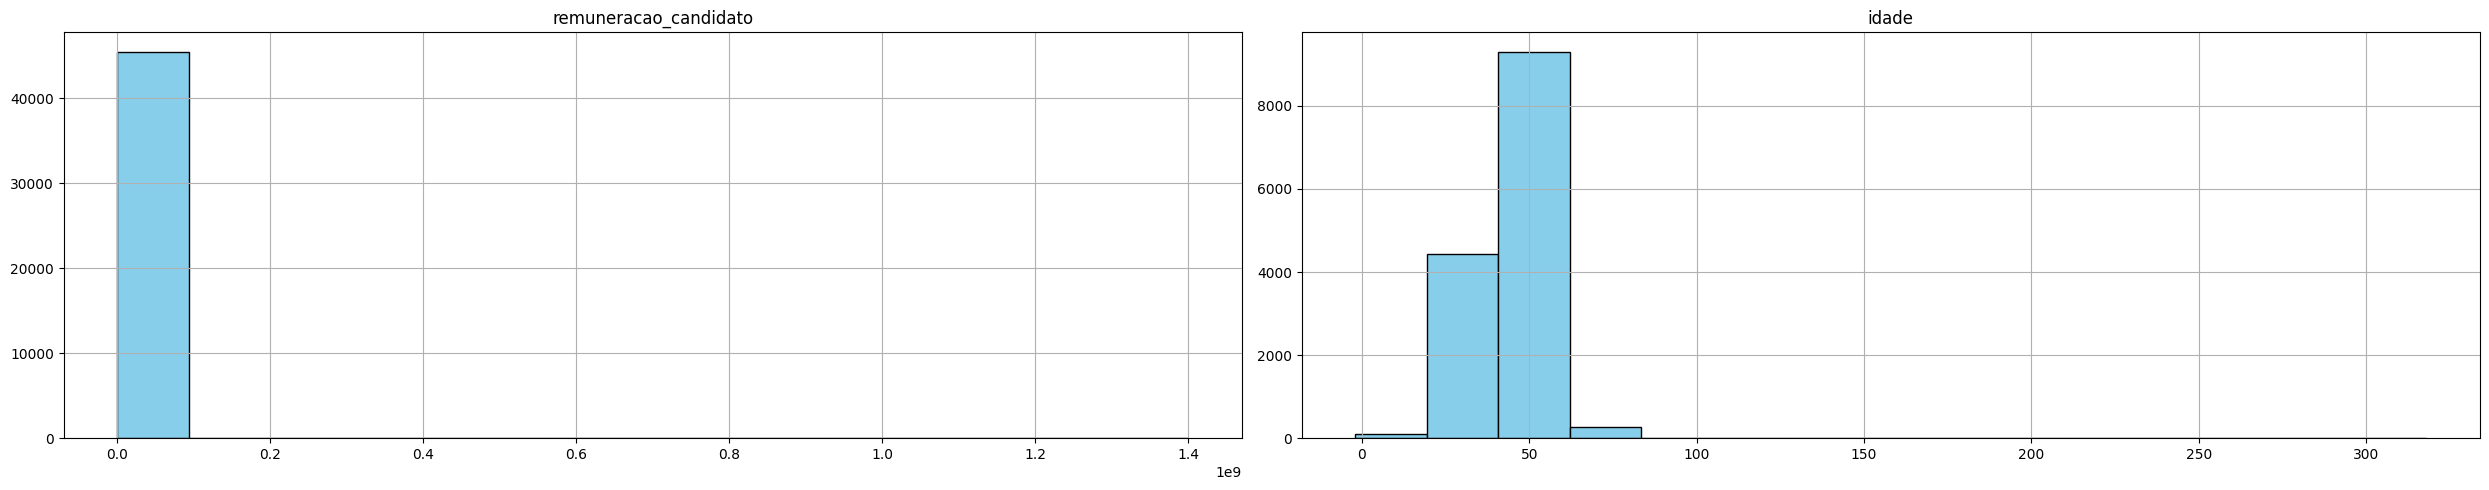

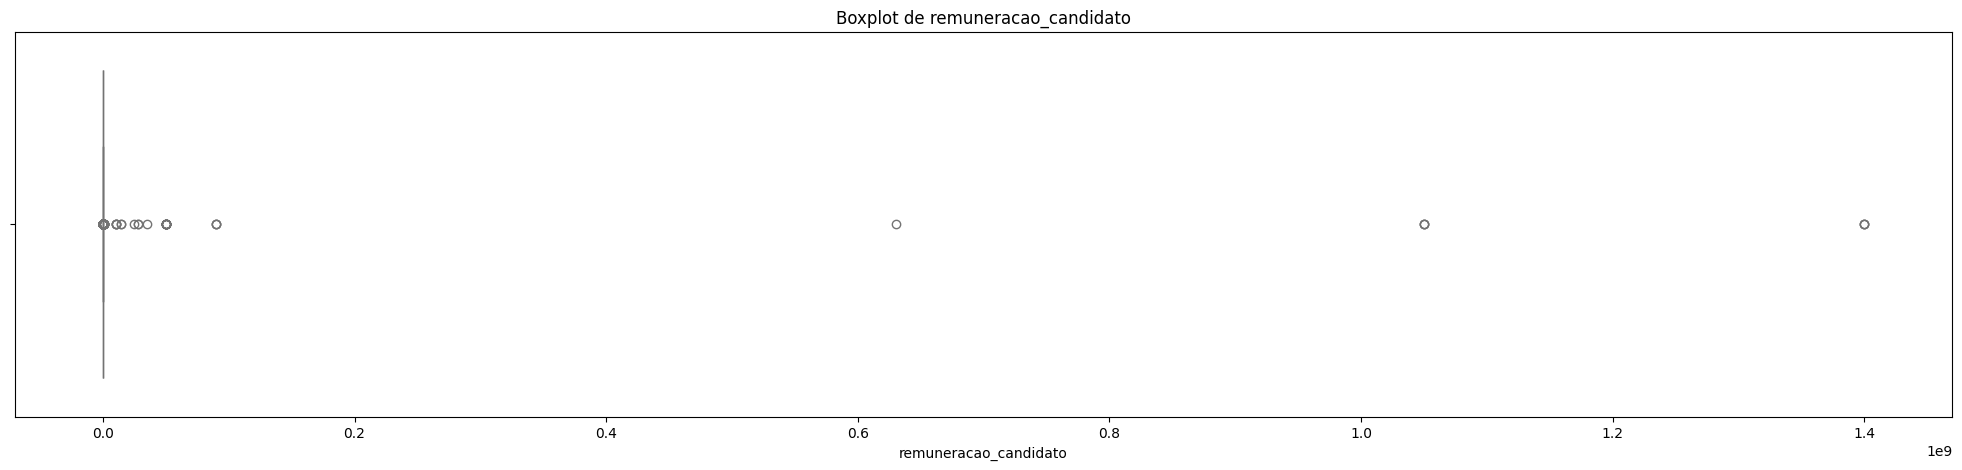

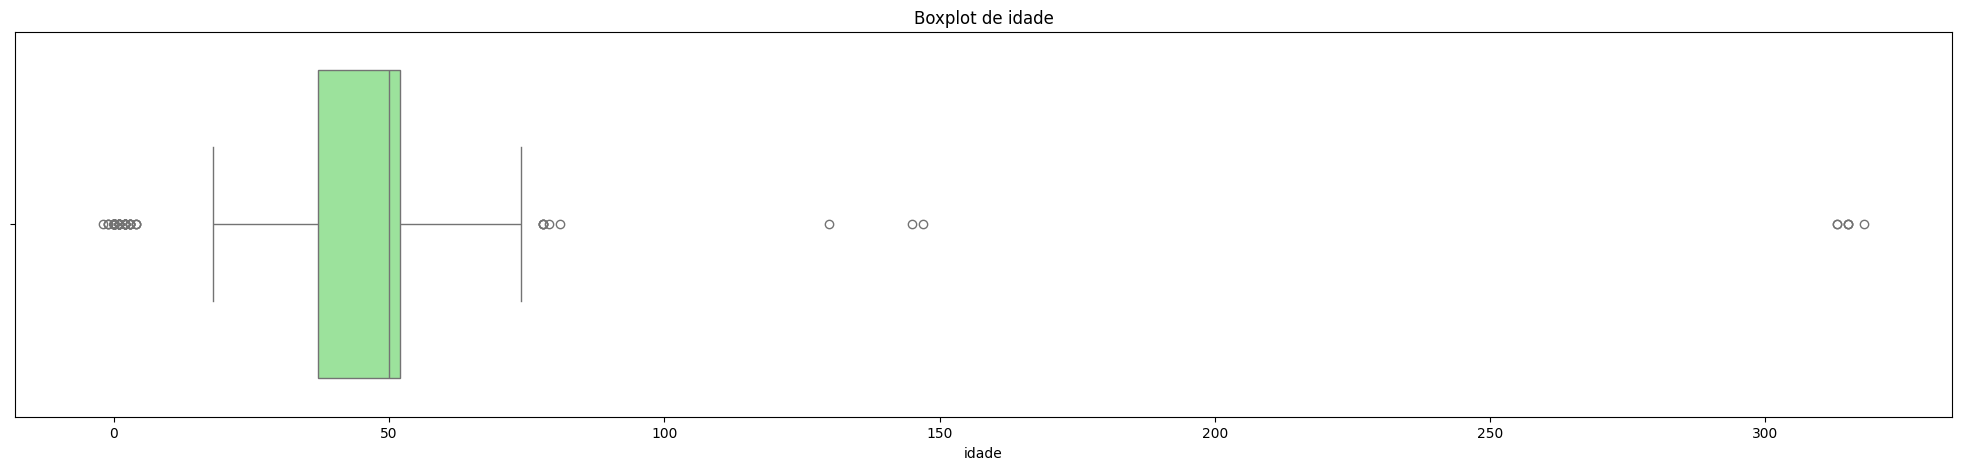

In [27]:
# Histograma para variáveis numéricas
numeric_columns = ['remuneracao_candidato', 'idade']
df[numeric_columns].hist(bins=15, figsize=(25, 5), color='skyblue', edgecolor='black')
plt.tight_layout()
plt.show()

# Boxplot para detectar outliers
for col in numeric_columns:
    plt.figure(figsize=(25, 5))
    sns.boxplot(x=df[col], color='lightgreen')
    plt.title(f'Boxplot de {col}')
    plt.show()

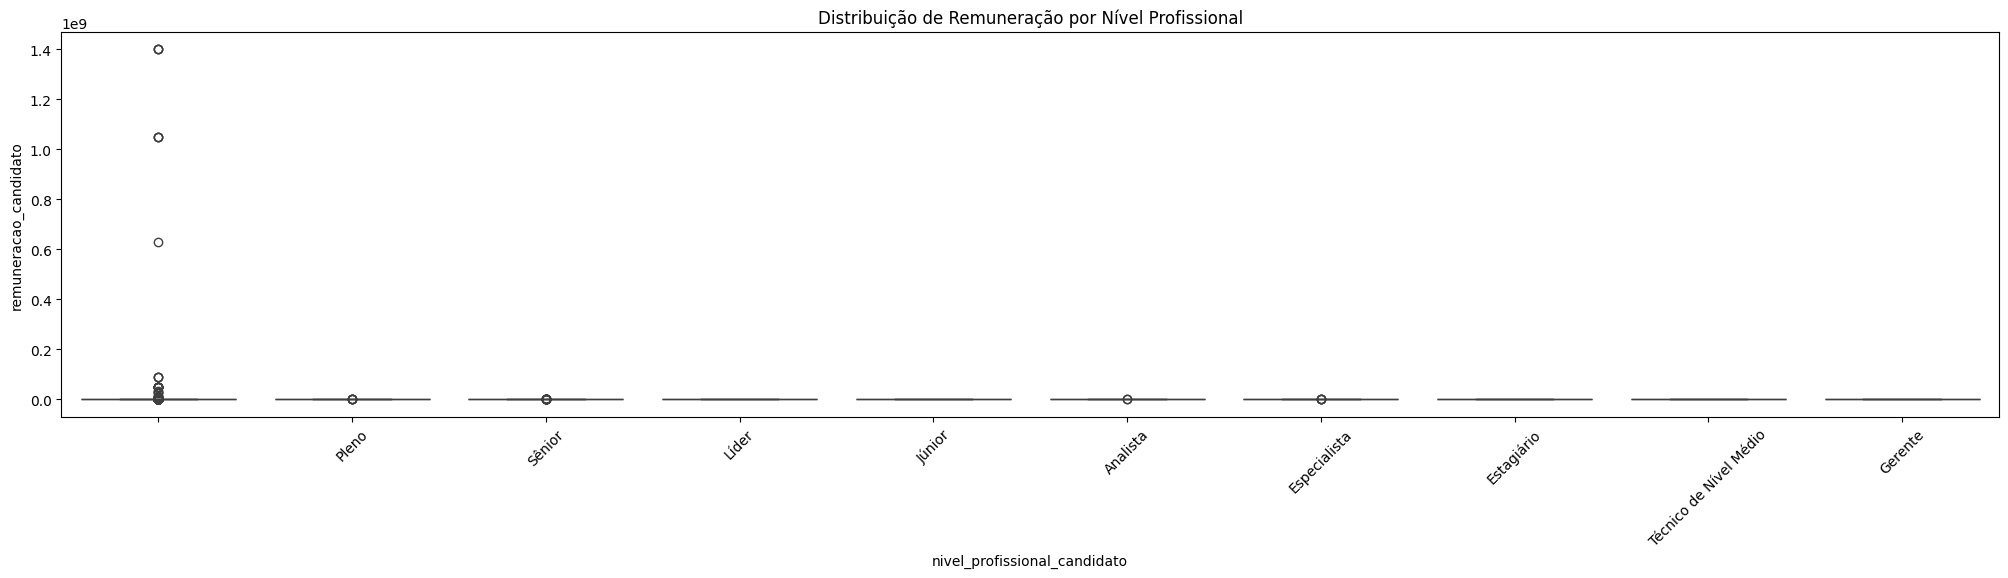

In [28]:
# Exemplo para 'remuneracao' e 'nivel_profissional'
plt.figure(figsize=(25, 5))
sns.boxplot(x='nivel_profissional_candidato', y='remuneracao_candidato', data=df)
plt.title('Distribuição de Remuneração por Nível Profissional')
plt.xticks(rotation=45)
plt.show()

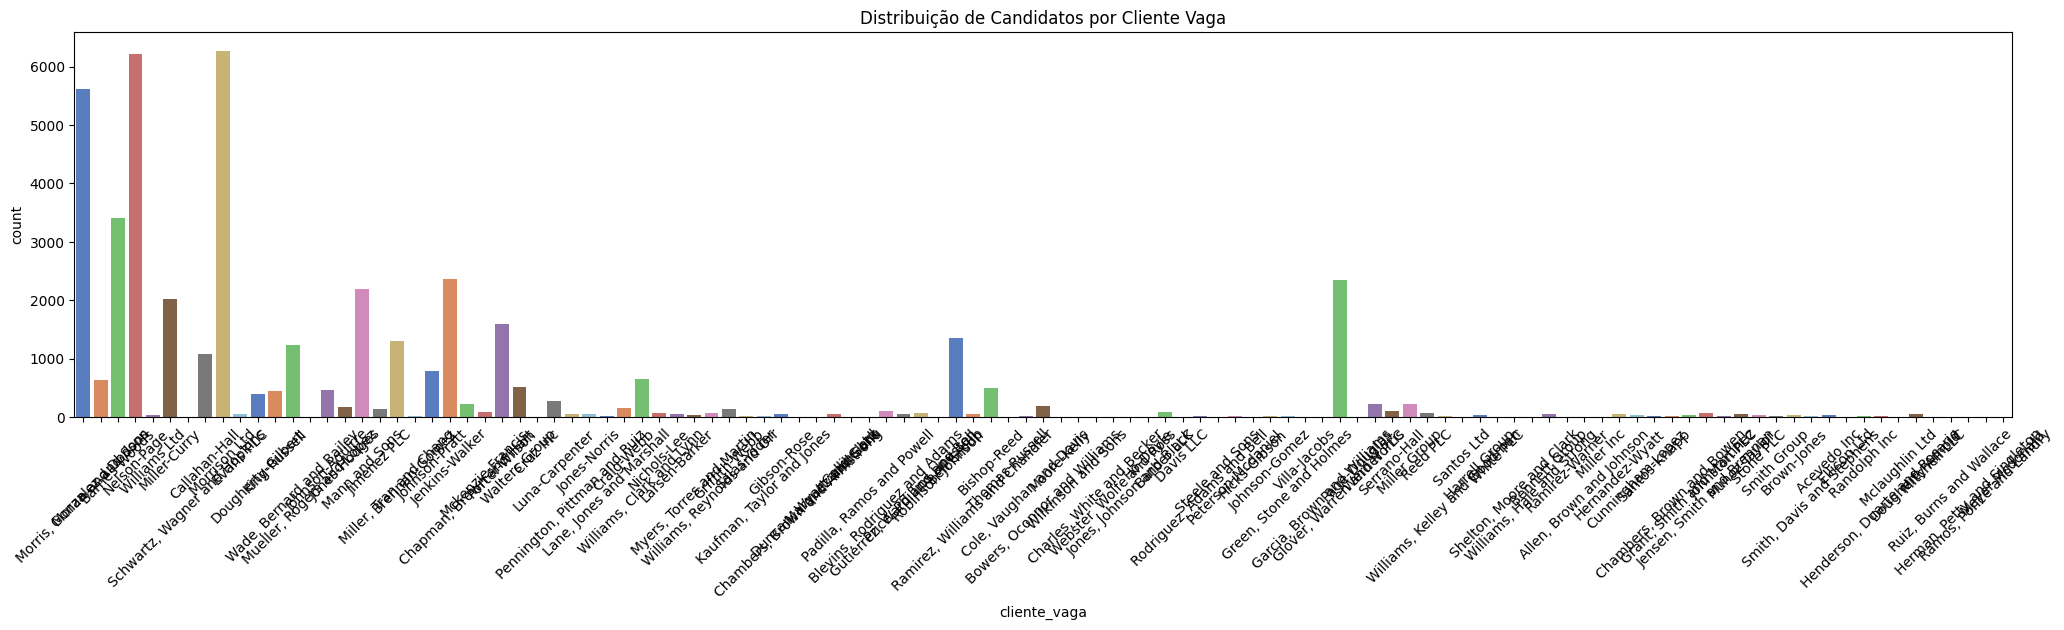

In [29]:
# Distribuição de candidatos por tipo de vaga
plt.figure(figsize=(25, 5))
sns.countplot(x='cliente_vaga', data=df, palette='muted')
plt.title('Distribuição de Candidatos por Cliente Vaga')
plt.xticks(rotation=45)
plt.show()

In [30]:
# Visualizando valores extremos
df[df['idade'] < 18].head(1)  # Se houver idades menores que 18, pode ser um erro

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
41,Prospect,Ana Camargo,"Brasília, Distrito Federal",Masculino,Solteiro,Não,10300,,Ensino Superior Completo,Intermediário,Básico,Sistemas de Informação,Gonzalez and Sons,Hunting,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Nenhum,Nenhum,Financeira/Controladoria-,0.0


In [31]:
# Visualizando valores extremos
df[df['remuneracao_candidato'] > 1000000].head(1)  # Verificando se há remunerações extremamente altas

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
4688,Prospect,Yasmin da Rosa,"Araguari, Minas Gerais",Masculino,Casado,Não,50001600,,Ensino Superior Completo,Intermediário,Básico,Engenharia de Controle e Automação,Jenkins-Walker,Hunting,Alta: Alta complexidade 3 a 5 dias,,São Leopoldo,Sênior,Ensino Superior Completo,Avançado,Avançado,TI - Infraestrutura-,49.0


Feature Engineering e pré-processamento

In [32]:
valores_positivos = ['Contratado pela Decision', 'Aprovado', 'Contratado como Hunting', 'Proposta Aceita']
df['situacao_candidado'] = df['situacao_candidado'].isin(valores_positivos).astype(int)

In [33]:
df['situacao_candidado'].value_counts()

situacao_candidado
0    42543
1     2942
Name: count, dtype: int64

In [34]:
df.head()

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
0,0,Ana Lívia Moreira,,,,,0,,,,,NaN,"Morris, Moran and Dodson",PJ/Autônomo,,,Rio de Janeiro,Pleno,Ensino Superior Completo,Nenhum,Nenhum,TI - Desenvolvimento/Programação-,NaN
1,0,Ana Lívia Moreira,"Rio de Janeiro, Rio de Janeiro",Masculino,Solteiro,Não,5600,,Ensino Superior Completo,Intermediário,Básico,,"Morris, Moran and Dodson",PJ/Autônomo,,,Rio de Janeiro,Pleno,Ensino Superior Completo,Nenhum,Nenhum,TI - Desenvolvimento/Programação-,48.0
2,1,Juliana Cassiano,"São Paulo, São Paulo",Masculino,Casado,Não,15,,Ensino Superior Completo,Avançado,Intermediário,Tecnologia da Informação,Gonzalez and Sons,PJ/Autônomo,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Nenhum,Nenhum,Gestão e Alocação de Recursos de TI-,48.0
3,0,Juliana Cassiano,,,,,0,,,,,NaN,Gonzalez and Sons,PJ/Autônomo,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Nenhum,Nenhum,Gestão e Alocação de Recursos de TI-,NaN
4,1,Stella Vieira,,,,,0,,,,,NaN,Barnes-Woods,PJ/Autônomo,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Técnico,Fluente,Gestão e Alocação de Recursos de TI-,NaN


In [35]:
# X: todas as colunas, exceto a variável target
X = df.drop(columns=["situacao_candidado"])

# y: apenas a variável target
y = df["situacao_candidado"]

In [36]:
# Remover linhas com qualquer valor NaN
X = X.dropna()
y = y[X.index]  # Manter o mesmo índice de X

In [37]:
# Label Encoding (Se as categorias forem ordinais, ou seja, possuem uma ordem)
# Supondo que 'coluna_categorica' seja a sua coluna categórica

le = LabelEncoder()

# Lista das colunas a codificar
colunas_categoricas = ['nivel_profissional_candidato', 'nivel_academico_candidato', 'nivel_ingles_candidato', 
                       'nivel_espanhol_candidato', 'prioridade_vaga', 'nivel_profissional_vaga', 
                       'nivel_academico_vaga', 'nivel_ingles_vaga', 'nivel_espanhol_vaga', 'sexo', 'estado_civil', 'pcd','recrutador', 'cidade_candidato','cursos_candidato','cliente_vaga', 'tipo_contratacao',
                       'origem_vaga', 'cidade_vaga','areas_atuacao_vaga']

# Aplicando o LabelEncoder em cada coluna categórica
for coluna in colunas_categoricas:
    X[coluna] = le.fit_transform(X[coluna])

In [38]:
df.head()

,situacao_candidado,recrutador,cidade_candidato,sexo,estado_civil,pcd,remuneracao_candidato,nivel_profissional_candidato,nivel_academico_candidato,nivel_ingles_candidato,nivel_espanhol_candidato,cursos_candidato,cliente_vaga,tipo_contratacao,prioridade_vaga,origem_vaga,cidade_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,idade
0,0,Ana Lívia Moreira,,,,,0,,,,,NaN,"Morris, Moran and Dodson",PJ/Autônomo,,,Rio de Janeiro,Pleno,Ensino Superior Completo,Nenhum,Nenhum,TI - Desenvolvimento/Programação-,NaN
1,0,Ana Lívia Moreira,"Rio de Janeiro, Rio de Janeiro",Masculino,Solteiro,Não,5600,,Ensino Superior Completo,Intermediário,Básico,,"Morris, Moran and Dodson",PJ/Autônomo,,,Rio de Janeiro,Pleno,Ensino Superior Completo,Nenhum,Nenhum,TI - Desenvolvimento/Programação-,48.0
2,1,Juliana Cassiano,"São Paulo, São Paulo",Masculino,Casado,Não,15,,Ensino Superior Completo,Avançado,Intermediário,Tecnologia da Informação,Gonzalez and Sons,PJ/Autônomo,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Nenhum,Nenhum,Gestão e Alocação de Recursos de TI-,48.0
3,0,Juliana Cassiano,,,,,0,,,,,NaN,Gonzalez and Sons,PJ/Autônomo,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Nenhum,Nenhum,Gestão e Alocação de Recursos de TI-,NaN
4,1,Stella Vieira,,,,,0,,,,,NaN,Barnes-Woods,PJ/Autônomo,Média: Média complexidade 6 a 10 dias,Nova Posição,São Paulo,Sênior,Ensino Médio Completo,Técnico,Fluente,Gestão e Alocação de Recursos de TI-,NaN


In [39]:
# Balanceando a variável target
X, y = SMOTE().fit_resample(X, y)

In [40]:
# Normalização/Escalonamento dos dados
scaler = StandardScaler()
X_normalized = scaler.fit_transform(X)

In [41]:
# Remoção de Variáveis Irrelevantes
selector = SelectKBest(score_func=f_classif, k=10)  # Escolhe as 10 melhores variáveis
X_selected = selector.fit_transform(X_normalized, y)

# Ver quais variáveis foram selecionadas
selected_features = X.columns[selector.get_support()]
selected_features

Index(['sexo', 'nivel_ingles_candidato', 'tipo_contratacao', 'prioridade_vaga',
       'origem_vaga', 'nivel_profissional_vaga', 'nivel_academico_vaga',
       'nivel_ingles_vaga', 'nivel_espanhol_vaga', 'areas_atuacao_vaga'],
      dtype='object')

In [42]:
# Identificando outliers
z_scores = stats.zscore(X_selected)
outliers = (z_scores > 3).any(axis=1)

# Remover outliers
X_no_outliers = X_selected[~outliers]
y_no_outliers = y[~outliers]

In [43]:
df.shape

(45485, 23)

In [44]:

# Transformando X_selected de volta para um DataFrame com os nomes das variáveis selecionadas
df = pd.DataFrame(X_selected, columns=selected_features)

# Adicionando a coluna y como 'situacao_candidato'
df['situacao_candidato'] = y.values

# Visualizando o DataFrame resultante
df.head()

,sexo,nivel_ingles_candidato,tipo_contratacao,prioridade_vaga,origem_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga,situacao_candidato
0,0.590955,1.371753,1.022561,-0.981190,-1.002799,0.487437,0.057265,1.366370,0.936125,-0.087668,0
1,0.590955,-0.974091,1.022561,3.160078,0.894692,0.934520,-1.528225,1.366370,0.936125,-1.514051,1
2,0.590955,0.589805,1.022561,3.160078,0.894692,0.934520,-1.528225,2.052761,0.936125,-1.514051,0
3,0.590955,-0.192143,1.022561,3.160078,0.894692,0.934520,-1.528225,2.052761,0.936125,-1.514051,0
4,0.590955,1.371753,1.335392,0.399233,-1.002799,-1.524433,0.057265,-0.692803,-0.962354,0.656532,0


In [45]:
df.shape

(15200, 11)

In [46]:


# Converta X_selected de volta para um DataFrame (com as colunas originais)
X = pd.DataFrame(X_selected, columns=['sexo', 'nivel_ingles_candidato', 'tipo_contratacao', 
                                                  'prioridade_vaga', 'origem_vaga', 'nivel_profissional_vaga', 
                                                  'nivel_academico_vaga', 'nivel_ingles_vaga', 'nivel_espanhol_vaga', 
                                                  'areas_atuacao_vaga'])

# Adiciona uma constante para a regressão
X_with_const = add_constant(X)

# Calcula o VIF para cada variável
vif_data = pd.DataFrame()
vif_data["Variable"] = X_with_const.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i) for i in range(X_with_const.shape[1])]
print(vif_data)

                   Variable       VIF
0                     const  1.000000
1                      sexo  1.071465
2    nivel_ingles_candidato  1.069563
3          tipo_contratacao  1.167851
4           prioridade_vaga  1.395264
5               origem_vaga  1.200924
6   nivel_profissional_vaga  1.541297
7      nivel_academico_vaga  1.152527
8         nivel_ingles_vaga  1.438966
9       nivel_espanhol_vaga  1.835015
10       areas_atuacao_vaga  1.419825


In [47]:
X.head()

,sexo,nivel_ingles_candidato,tipo_contratacao,prioridade_vaga,origem_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga
0,0.590955,1.371753,1.022561,-0.981190,-1.002799,0.487437,0.057265,1.366370,0.936125,-0.087668
1,0.590955,-0.974091,1.022561,3.160078,0.894692,0.934520,-1.528225,1.366370,0.936125,-1.514051
2,0.590955,0.589805,1.022561,3.160078,0.894692,0.934520,-1.528225,2.052761,0.936125,-1.514051
3,0.590955,-0.192143,1.022561,3.160078,0.894692,0.934520,-1.528225,2.052761,0.936125,-1.514051
4,0.590955,1.371753,1.335392,0.399233,-1.002799,-1.524433,0.057265,-0.692803,-0.962354,0.656532


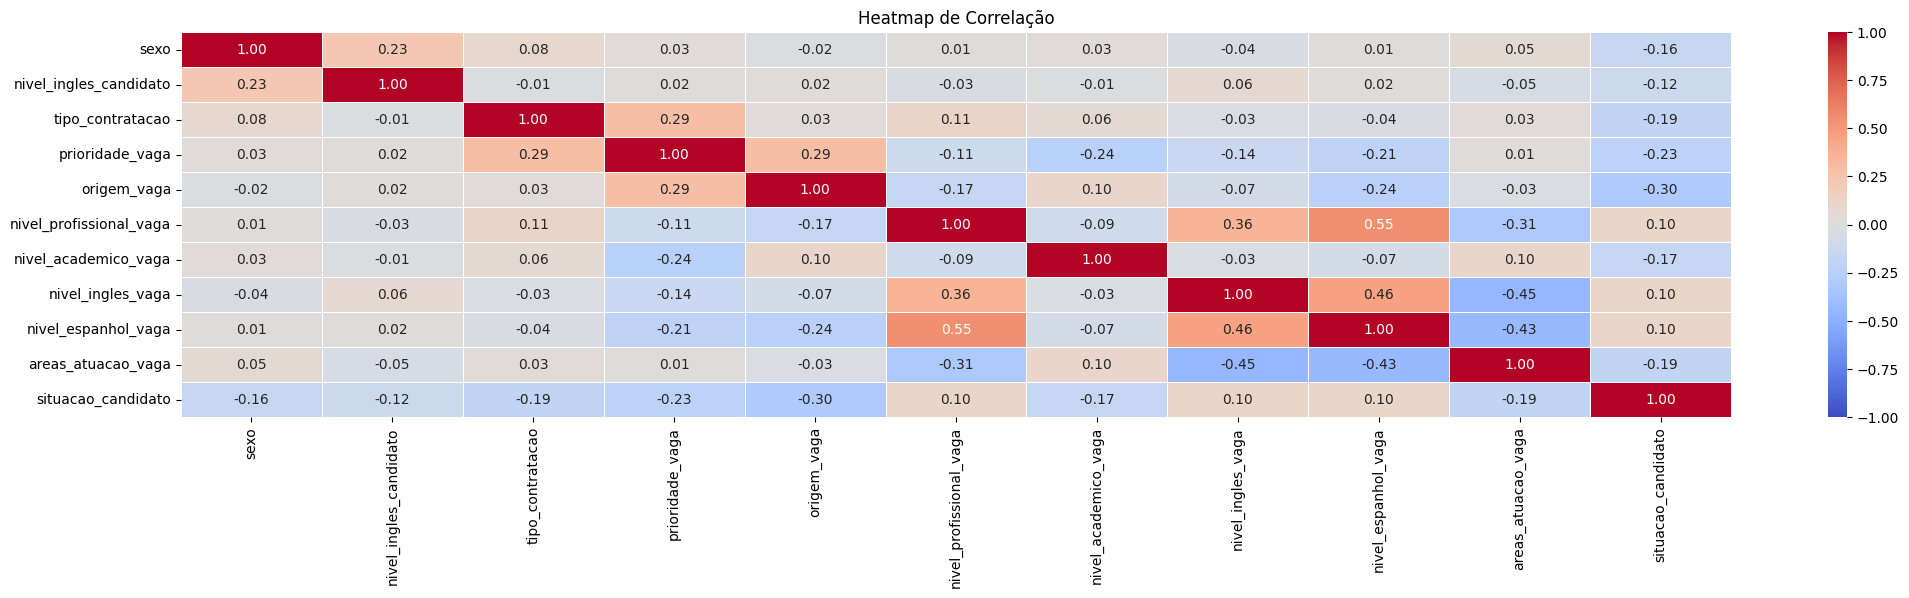

In [48]:

# Calcula a correlação
correlation_matrix = df.corr()

# Ajusta o tamanho da figura
plt.figure(figsize=(25, 5))

# Cria o heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, vmin=-1, vmax=1)

# Título
plt.title("Heatmap de Correlação")

# Exibir o gráfico
plt.show()

In [49]:
df.corr()["situacao_candidato"]

sexo                      -0.161331
nivel_ingles_candidato    -0.118270
tipo_contratacao          -0.193256
prioridade_vaga           -0.225772
origem_vaga               -0.297232
nivel_profissional_vaga    0.102976
nivel_academico_vaga      -0.167833
nivel_ingles_vaga          0.101965
nivel_espanhol_vaga        0.104208
areas_atuacao_vaga        -0.188184
situacao_candidato         1.000000
Name: situacao_candidato, dtype: float64

In [50]:
"""Em geral:
Correlação forte: |r| ≥ 0.5
Correlação moderada: 0.3 ≤ |r| < 0.5
Correlação fraca: |r| < 0.3"""

'Em geral:\nCorrelação forte: |r| ≥ 0.5\nCorrelação moderada: 0.3 ≤ |r| < 0.5\nCorrelação fraca: |r| < 0.3'

Treinamento do modelo

2025/04/21 21:08:19 WARNING mlflow.utils.autologging_utils: Encountered unexpected error during sklearn autologging: The following failures occurred while performing one or more logging operations: [MlflowException('Failed to perform one or more operations on the run with ID 2b5481c357c34fae9a3a581c08584504. Failed operations: [RestException("INVALID_PARAMETER_VALUE: Changing param values is not allowed. Params were already logged=\'[{\'key\': \'random_state\', \'old_value\': \'42\', \'new_value\': \'None\'}]\' for run ID=\'2b5481c357c34fae9a3a581c08584504\'.")]')]


Acurácia: 73.72%


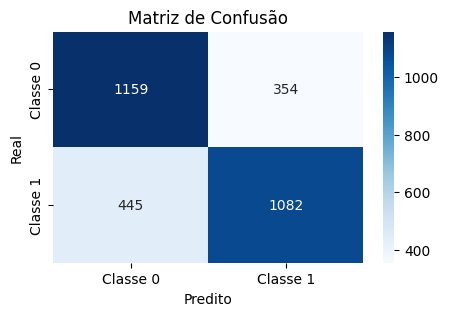

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.72      0.77      0.74      1513
           1       0.75      0.71      0.73      1527

    accuracy                           0.74      3040
   macro avg       0.74      0.74      0.74      3040
weighted avg       0.74      0.74      0.74      3040

🏃 View run smiling-pig-471 at: http://localhost:9000/#/experiments/1/runs/2b5481c357c34fae9a3a581c08584504
🧪 View experiment at: http://localhost:9000/#/experiments/1


In [51]:

# Divisão entre dados de treino e teste (80% treino, 20% teste)
import mlflow.sklearn

with mlflow.start_run():

    mlflow.sklearn.autolog()

    _random_state = 42
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=_random_state)

    mlflow.log_param("random_state", _random_state)


    # Instancia o modelo de Regressão Logística
    model = LogisticRegression(max_iter=1000, penalty=None)

    # Treina o modelo com os dados de treino
    model.fit(X_train, y_train)

    # Realiza previsões nos dados de teste
    y_pred = model.predict(X_test)

    # Avalia o desempenho do modelo
    accuracy = accuracy_score(y_test, y_pred) * 100  # Acurácia em porcentagem
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Exibe a acurácia em porcentagem
    print(f'Acurácia: {accuracy:.2f}%')

    # Exibe a Matriz de Confusão como um Heatmap
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Classe 0', 'Classe 1'], yticklabels=['Classe 0', 'Classe 1'])
    plt.title('Matriz de Confusão')
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.show()

    # Relatório de Classificação
    print(f'Relatório de Classificação:\n{classification_report(y_test, y_pred)}')

Acurácia: 93.45%
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.92      0.95      0.94      1513
           1       0.95      0.91      0.93      1527

    accuracy                           0.93      3040
   macro avg       0.94      0.93      0.93      3040
weighted avg       0.94      0.93      0.93      3040



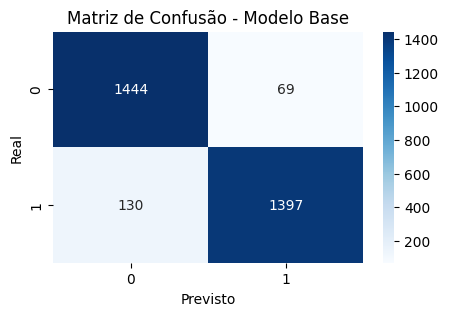

Fitting 3 folds for each of 48 candidates, totalling 144 fits


2025/04/21 21:08:37 INFO mlflow.sklearn.utils: Logging the 5 best runs, 43 runs will be omitted.


🏃 View run tasteful-bird-159 at: http://localhost:9000/#/experiments/1/runs/37490e4daf6947459acf56e59a54814e
🧪 View experiment at: http://localhost:9000/#/experiments/1
🏃 View run dazzling-horse-971 at: http://localhost:9000/#/experiments/1/runs/290c387c547e473da006bd00c401768f
🧪 View experiment at: http://localhost:9000/#/experiments/1
🏃 View run agreeable-steed-5 at: http://localhost:9000/#/experiments/1/runs/c17cb2f9a4bf4d27963844f92265579d
🧪 View experiment at: http://localhost:9000/#/experiments/1
🏃 View run placid-stoat-994 at: http://localhost:9000/#/experiments/1/runs/4e8a6febff36484eb06fbf9f3fcfc64e
🧪 View experiment at: http://localhost:9000/#/experiments/1
🏃 View run skillful-mule-797 at: http://localhost:9000/#/experiments/1/runs/4e3c581bcd9e4966b824e2b051bd98d3
🧪 View experiment at: http://localhost:9000/#/experiments/1
Melhores hiperparâmetros: {'learning_rate': 0.4, 'max_depth': 7, 'n_estimators': 150}
Melhor acurácia (validação cruzada): 93.63%
Relatório de Classificaçã

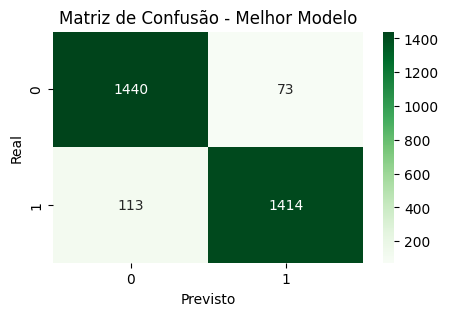

🏃 View run aged-yak-48 at: http://localhost:9000/#/experiments/1/runs/bde017054d7e4901a2c10a40f802f674
🧪 View experiment at: http://localhost:9000/#/experiments/1


In [52]:

# 🔹 Dividindo em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

with mlflow.start_run():
        
    # 🔹 Criando e treinando o modelo XGBoost
    model = XGBClassifier(use_label_encoder=False, eval_metric="logloss")
    model.fit(X_train, y_train)

    # 🔹 Fazendo previsões
    y_pred = model.predict(X_test)

    # 🔹 Avaliação do modelo
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"Acurácia: {accuracy:.2%}")
    print("Relatório de Classificação:\n", report)

    # 🔹 Matriz de confusão
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão - Modelo Base")
    plt.show()

    # 🔹 Ajuste de hiperparâmetros com GridSearchCV
    param_grid = {
        'n_estimators': [100, 150, 200],
        'max_depth': [3, 5, 7, 11],
        'learning_rate': [0.01, 0.1, 0.3, 0.4]
    }

    grid_search = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric="logloss"), 
                            param_grid, cv=3, scoring='accuracy', verbose=1, n_jobs=-1)

    grid_search.fit(X_train, y_train)

    # 🔹 Melhor modelo encontrado
    best_model = grid_search.best_estimator_
    best_accuracy = grid_search.best_score_

    print(f"Melhores hiperparâmetros: {grid_search.best_params_}")
    print(f"Melhor acurácia (validação cruzada): {best_accuracy:.2%}")

    # 🔹 Avaliação no conjunto de teste
    y_pred_best = best_model.predict(X_test)
    print("Relatório de Classificação (Melhor Modelo):\n", classification_report(y_test, y_pred_best))

    # 🔹 Matriz de confusão do melhor modelo
    conf_matrix_best = confusion_matrix(y_test, y_pred_best)
    plt.figure(figsize=(5, 3))
    sns.heatmap(conf_matrix_best, annot=True, fmt="d", cmap="Greens", xticklabels=[0, 1], yticklabels=[0, 1])
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão - Melhor Modelo")
    plt.show()


In [53]:
# a acurácia do modelo melhorou muito. Precision, recall e f1-score estão bem equilibrados, então o modelo já está ótimo

Validação do modelo

Acurácia no conjunto de validação: 93.88%
Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.93      0.95      0.94      1513
           1       0.95      0.93      0.94      1527

    accuracy                           0.94      3040
   macro avg       0.94      0.94      0.94      3040
weighted avg       0.94      0.94      0.94      3040



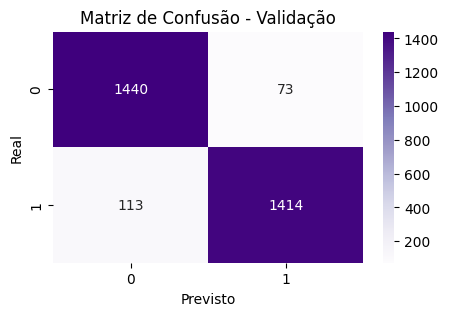

🏃 View run Validação at: http://localhost:9000/#/experiments/1/runs/787508b9f6684d4daf756b43e188db23
🧪 View experiment at: http://localhost:9000/#/experiments/1


In [ ]:


# 🔹 Fazer previsões no conjunto de validação
y_val_pred = best_model.predict(X_test)

# 🔹 Avaliar desempenho
accuracy = accuracy_score(y_test, y_val_pred)
print(f"Acurácia no conjunto de validação: {accuracy:.2%}")

print("Relatório de Classificação:\n", classification_report(y_test, y_val_pred))

# 🔹 Matriz de Confusão

conf_matrix = confusion_matrix(y_test, y_val_pred)
plt.figure(figsize=(5, 3))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Purples", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.title("Matriz de Confusão - Validação")
plt.show()

In [ ]:
# Acurácia no conjunto de validação está praticamente idêntica à do treino , indicando que o modelo não está overfittado e generaliza bem

In [ ]:

cv_scores = cross_val_score(best_model, X, y, cv=5, scoring='accuracy')
print(f"Acurácia Média (Cross Validation): {cv_scores.mean():.2%}")
print(f"Desvio Padrão: {cv_scores.std():.2%}")

Acurácia Média (Cross Validation): 90.74%
Desvio Padrão: 3.69%


In [ ]:
# A acurácia média no Cross Validation é boa, mas um pouco menor do que no conjunto de teste
# O desvio padrão sugere uma variação razoável entre os folds. Isso significa que o modelo pode estar sofrendo um pouco de sensibilidade aos dados de treino.

In [ ]:
# Identificar exemplos que o modelo previu errado
erros = X_test[y_test != y_val_pred]
erros.head()

,sexo,nivel_ingles_candidato,tipo_contratacao,prioridade_vaga,origem_vaga,nivel_profissional_vaga,nivel_academico_vaga,nivel_ingles_vaga,nivel_espanhol_vaga,areas_atuacao_vaga
7934,0.602529,0.588025,0.269538,1.341620,0.400507,0.897412,-1.529133,0.071498,-0.974948,0.969958
4295,0.602529,-0.193199,0.980201,-1.162053,0.400507,0.897412,-1.529133,0.071498,-0.974948,-0.076233
11917,0.602529,0.588025,-1.151789,-1.266373,-0.979925,0.897412,-1.529133,0.071498,-0.974948,1.154580
8524,0.602529,1.369248,0.980201,0.611382,-0.979925,0.897412,0.481704,0.071498,-0.974948,-0.076233
3941,0.602529,0.588025,-0.441126,1.341620,0.400507,-0.997915,-1.529133,0.071498,-0.974948,0.662254


In [ ]:
# O modelo já está bem testado e validado
# ✔ Acurácia alta e estável → no conjunto de validação e no Cross Validation.
# ✔ Sem overfitting grave → Pequena diferença entre treino e teste, sem queda brusca de performance.
# ✔ Cross Validation feito → O modelo foi avaliado em diferentes amostras dos dados.
# ✔ Relatórios de classificação analisados → Precision, Recall e F1-score equilibrados.
# ✔ Matriz de confusão revisada → Nenhuma distorção grave na previsão das classes.

In [ ]:

# 🔹 Salvando o modelo
joblib.dump(best_model, "modelo_xgboost.joblib")

# 🔹 Carregando o modelo posteriormente
modelo_carregado = joblib.load("modelo_xgboost.joblib")

# Teste de carregamento
print(modelo_carregado.predict(X_test[:5]))

[0 0 0 1 0]
